# Notebook to plot power spectra and CF for the halos and cdm

## Loading packages

In [1]:
import numpy as np
# import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 16).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate


## Nested dictionary

In [2]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(5, list)
pow_gev = nested_dict(2, list)
class_data = nested_dict(3, list)
rsd_coeff = nested_dict(2, list)


## Loading power and CF data

In [3]:
directory = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Powerpsectra_correlationfunction_particles_Pylians/"
directory_halo = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Power_spectra_correlation_function_RSD_noRSD_Halos/"
directory_power = "/Users/farbod/Dropbox/Projects/Doppler_RSD//Data/kevolution_gevolution_power_output/"

files=["gevolution_boxsize_4032_ngrid_4608_lcdm_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_1_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020",
       "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em4_05062020",
        "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020"];

redshifts = ["0", "0.5", "1", "2", "3"];
files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];


#############    
### Pylians #
#############
for j in range(5): # file
    for i in range(5): # redshift
        if (j==0):
            data['cdm']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/RSD_pcls///pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
            data['cdm']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/RSD_pcls/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        else:
            data['cdm']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/RSD_wcdm_pcls//pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
            data['cdm']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/RSD_wcdm_pcls/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");

        data['cdm']['noRSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory+"/no_RSD/pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['cdm']['noRSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory+"/no_RSD/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['noRSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_halo+"/no_RSD//pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['RSD'][files_list[j]]['pow']['z='+str(redshifts[i])]=load(directory_halo+"/RSD/pk3D_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['noRSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory_halo+"/no_RSD//CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        data['halo']['RSD'][files_list[j]]['cor']['z='+str(redshifts[i])]=load(directory_halo+"/RSD/CF_full_"+files[j]+"_z_"+str(redshifts[i])+".npy");
        
#############    
### CLASS ###
#############
directory_class = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/CLASS_powers/"
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];
redshifts_class = [100, 50, 30, 10, 4, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0];
# CLASS data loading:
for j in range(4):
    
    class_data['bg'][files_list_class[j]]=np.loadtxt(directory_class+files_list_class[j]+"/background.dat");
    for i in range(np.shape(redshifts_class)[0]): # redshift
        class_data['power_cb_lin'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb.dat");
        class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb_nl.dat");
        class_data['tk'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_tk.dat")

# CLASS conversion :
k_pivot = 0.05
A_s = 2.1e-9
n_s = 0.96
h = 0.67
k_class = class_data['tk'][files_list_class[0]]["z=0"][:,0]
conversion = A_s*(k_class*h/k_pivot)**(n_s-1)*(2.*np.pi**2/(k_class**3));

# RSD coefficient:
z_f = [0,0.5,1,2,3]
bias = 1;
for i in range(4): # file
     for j in range(5): # redshift
            if(i==0):
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,22];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                f_gr = bg_file_interp(z_f[j]);
                rsd_coeff[files_list_class[i]]['z='+str(z_f[j])] = (bias**2 + 2.0 * bias * f_gr/3. + f_gr**2/5.)
                
            else:
                z = class_data['bg'][files_list_class[i]][:,0];
                gr_f = class_data['bg'][files_list_class[i]][:,24];
                bg_file_interp = interpolate.interp1d(z,gr_f)
                f_gr = bg_file_interp(z_f[j]);
                rsd_coeff[files_list_class[i]]['z='+str(z_f[j])] = (bias**2 + 2.0 * bias * f_gr/3. + f_gr**2/5.)



# Tests

In [4]:
data.keys()
class_data.keys()
class_data['Bg'].keys()
class_data['Bg']['lcdm'];
print(class_data['tk']['lcdm'].keys())
class_data['tk']['lcdm']['z=0'];

dict_keys(['z=100', 'z=50', 'z=30', 'z=10', 'z=4', 'z=3', 'z=2.5', 'z=2', 'z=1.5', 'z=1', 'z=0.75', 'z=0.5', 'z=0.25', 'z=0.1', 'z=0'])


# cdm Powerspectra comparison, no RSD

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


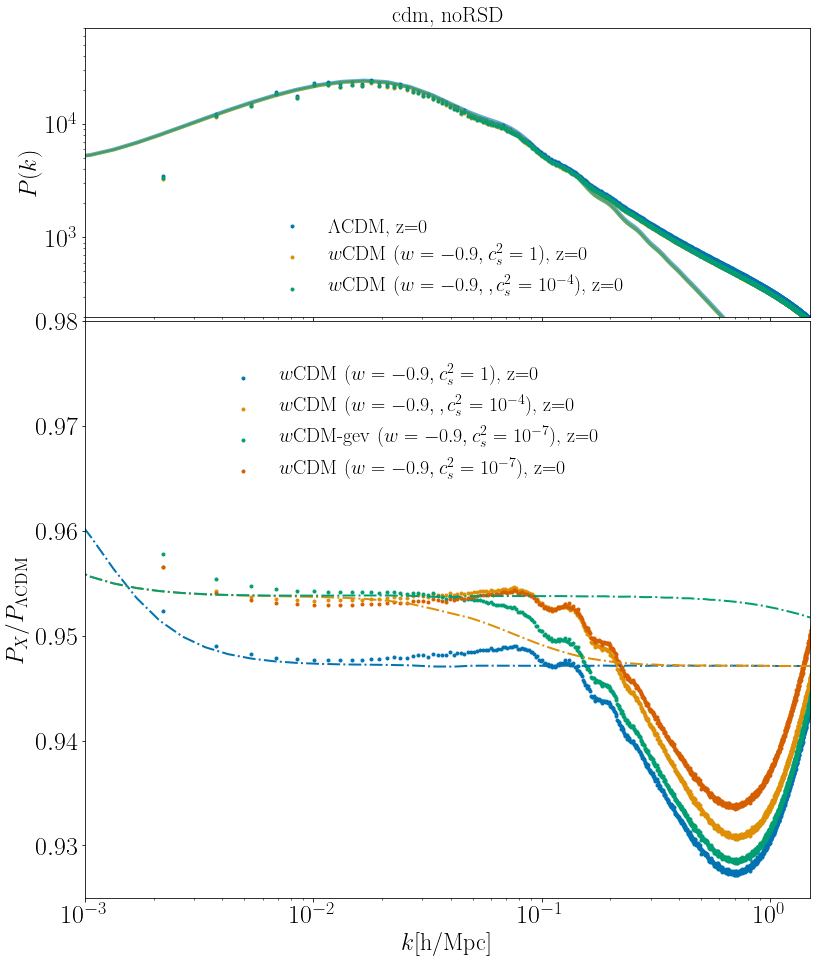

In [5]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)

        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
plt.xscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e2,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.5, 0.2], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,1],:]
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+redshift)
                l=l+1;

l=0
for num1 in [0,1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)

                axs[1].plot(k_w, (d_m/d_m_lcdm)**2,"-.",color =Colors[l], lw=2)
                l=l+1
axs[1].set_ylabel(r'$P_X/P_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.925,0.98)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.45,0.82],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('noRSD_cdm_compare.pdf', format='pdf',dpi=300, bbox_inches='tight' )


In [ ]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)

        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
plt.xscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e2,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.5, 0.2], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,1],:]
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+redshift)
                l=l+1;

l=0
for num1 in [0,1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)

                axs[1].plot(k_w, (d_m/d_m_lcdm)**2,"-.",color =Colors[l], lw=2)
                l=l+1
axs[1].set_ylabel(r'$P_X/P_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.925,0.98)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.45,0.82],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('noRSD_cdm_compare.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# cdm Powerspectra comparison,  RSD

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


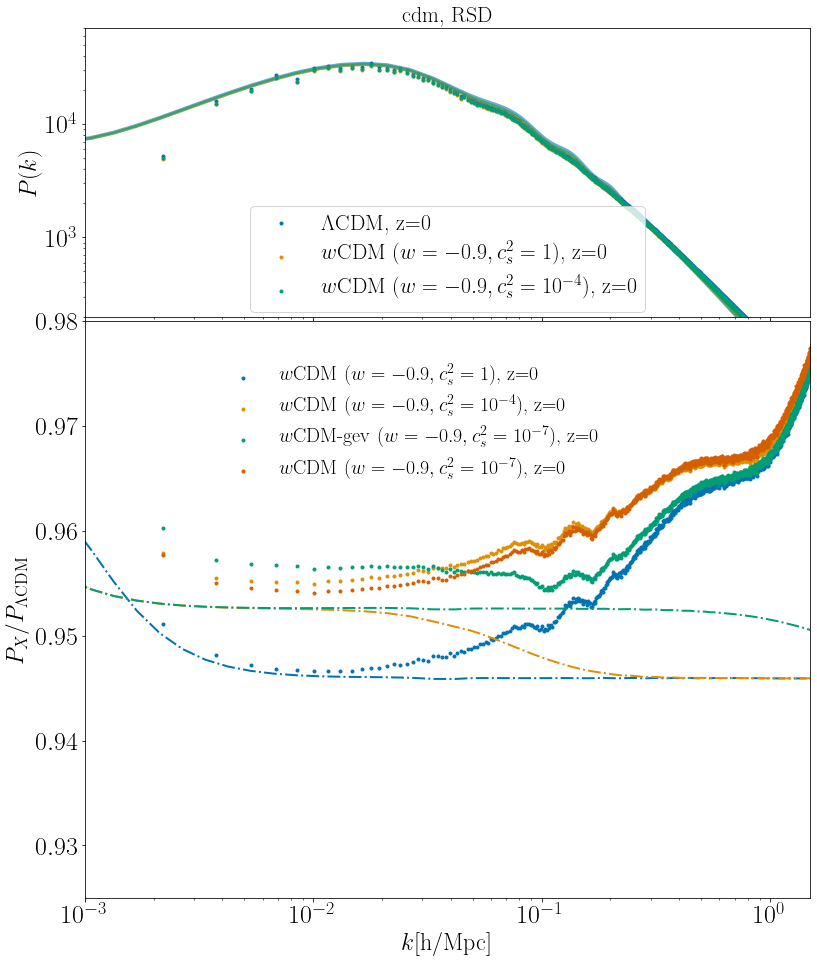

In [6]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)

        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * np.double(rsd_coeff[files_list_class[i]][redshift]) ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
plt.xscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e2,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.2], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,1],:]
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+redshift)
                l=l+1;

l=0
for num1 in [1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)
                RSD_lcdm =np.double(rsd_coeff[files_list_class[num2]][redshift])
                RSD_wcdm =np.double(rsd_coeff[files_list_class[num1]][redshift])

                axs[1].plot(k_w, (d_m**2*RSD_wcdm)/(d_m_lcdm**2*RSD_lcdm),"-.",color =Colors[l], lw=2)
                l=l+1

axs[1].set_ylabel(r'$P_X/P_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.925,0.98)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.45,0.82],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_cdm_compare.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# CDM power spectra, different sound speed for RSD and no RSD

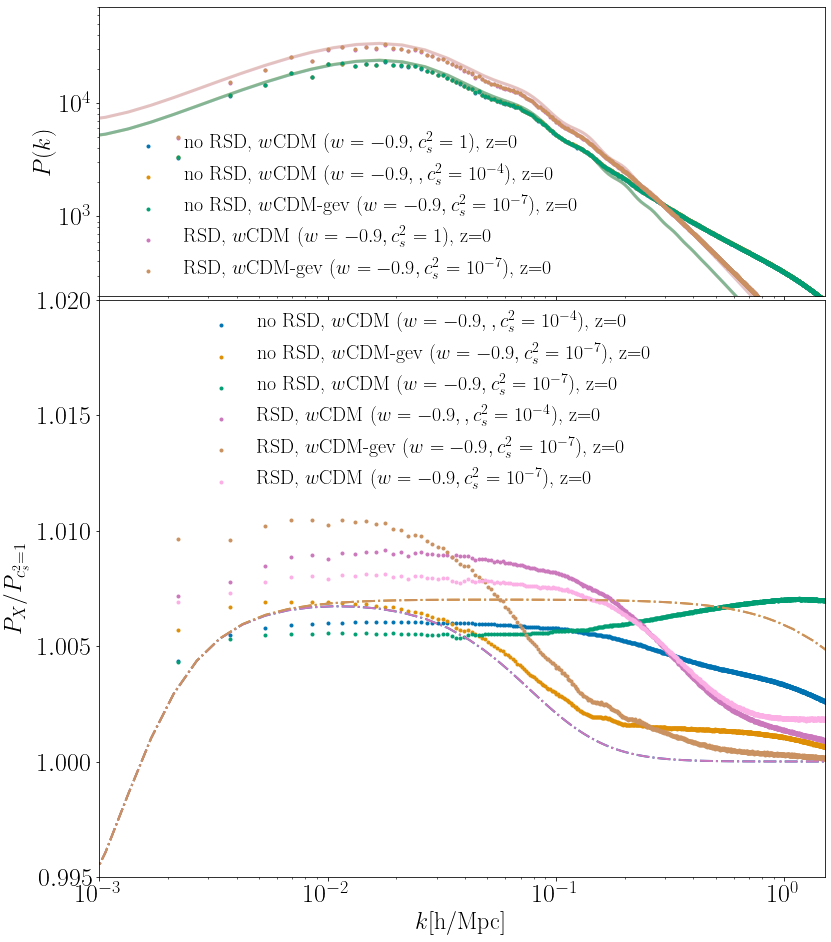

In [8]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'

file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [1,2,3]: # file
    for j in [0]: # Redshifts
        RSD ='noRSD'
        redshift ="z="+str(j);
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label="no RSD, "+decrip[i]+redshift)

        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.3,color =Colors[l], lw=3)        
        l=l+1

l=3
for i in [1,3]: # file
    for j in [0]: # Redshifts
        RSD ='RSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,1],:]  
        axs[0].plot(k_w,pk,".",color =Colors[l+1], lw=3,label="RSD, "+decrip[i]+redshift)
        k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
        pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * np.double(rsd_coeff[files_list_class[i]][redshift]) ,"-",alpha=0.3,color =Colors[l+1], lw=3)
        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
plt.xscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e2,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.35, 0.3], loc='center',frameon=False)
# axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
RSD ='noRSD'
for num1 in [2,3,4]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,1],:]
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="no RSD, "+decrip[num1]+" "+redshift)
                l=l+1;

l=0
for num1 in [1,2,3]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)

                axs[1].plot(k_w, (d_m/d_m_lcdm)**2,"-.",color =Colors[l], lw=2)
                l=l+1
                
l=4
                
# RSD part
RSD = "RSD"
for num1 in [2,3,4]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,1],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,1],:]
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="RSD, "+decrip[num1]+" "+redshift)
                l=l+1;


l=4
### CLASS transfer
for num1 in [2,3]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):

                ### CLASS transfer
                redshift ="z="+str(j);
                # Transfer function:
                # LCDM
                k_w_lcdm= class_data['tk'][files_list_class[num2]][redshift][:,0]
                d_cdm_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,3]
                d_b_lcdm =class_data['tk'][files_list_class[num2]][redshift][:,2]
                # densities from the bg file
                rho_cdm_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,10])
                rho_b_lcdm = interpolate.interp1d(class_data['bg'][files_list_class[num2]][:,0],class_data['bg'][files_list_class[num2]][:,9])
                d_m_lcdm = (d_cdm_lcdm * rho_cdm_lcdm(np.double(j))+ d_b_lcdm * rho_b_lcdm(np.double(j)))/(rho_cdm_lcdm(np.double(j))+ rho_b_lcdm(np.double(j)));
                interp_delta_lcdm=InterpolatedUnivariateSpline(k_w_lcdm,d_m_lcdm, k=2)

                #kessence
                k_w=class_data['tk'][files_list_class[num1]][redshift][:,0] 
                d_cdm =class_data['tk'][files_list_class[num1]][redshift][:,3]
                d_b =class_data['tk'][files_list_class[num1]][redshift][:,2]
                rho_cdm = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,10])
                rho_b = interpolate.interp1d(class_data['bg'][files_list_class[num1]][:,0],class_data['bg'][files_list_class[num1]][:,9])
                d_m = (d_cdm * rho_cdm(np.double(j)) 
                       + d_b * rho_b(np.double(j)))/(rho_cdm(np.double(j))+ rho_b(np.double(j)));
                interp_delta = InterpolatedUnivariateSpline(k_w,d_m, k=2)

                d_m = interp_delta (k_w)
                d_m_lcdm = interp_delta_lcdm (k_w)
                RSD_lcdm =np.double(rsd_coeff[files_list_class[num2]][redshift])
                RSD_wcdm =np.double(rsd_coeff[files_list_class[num1]][redshift])

                axs[1].plot(k_w, (d_m**2*RSD_wcdm)/(d_m_lcdm**2*RSD_lcdm),"-.",color =Colors[l], lw=2)
                l=l+1  

axs[1].set_ylabel(r'$P_X/P_{c_s^2=1}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(0.995,1.02)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.45,0.82],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('Soundspeed_cdm_compare.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# quadrupole, CDM,  RSD comparison

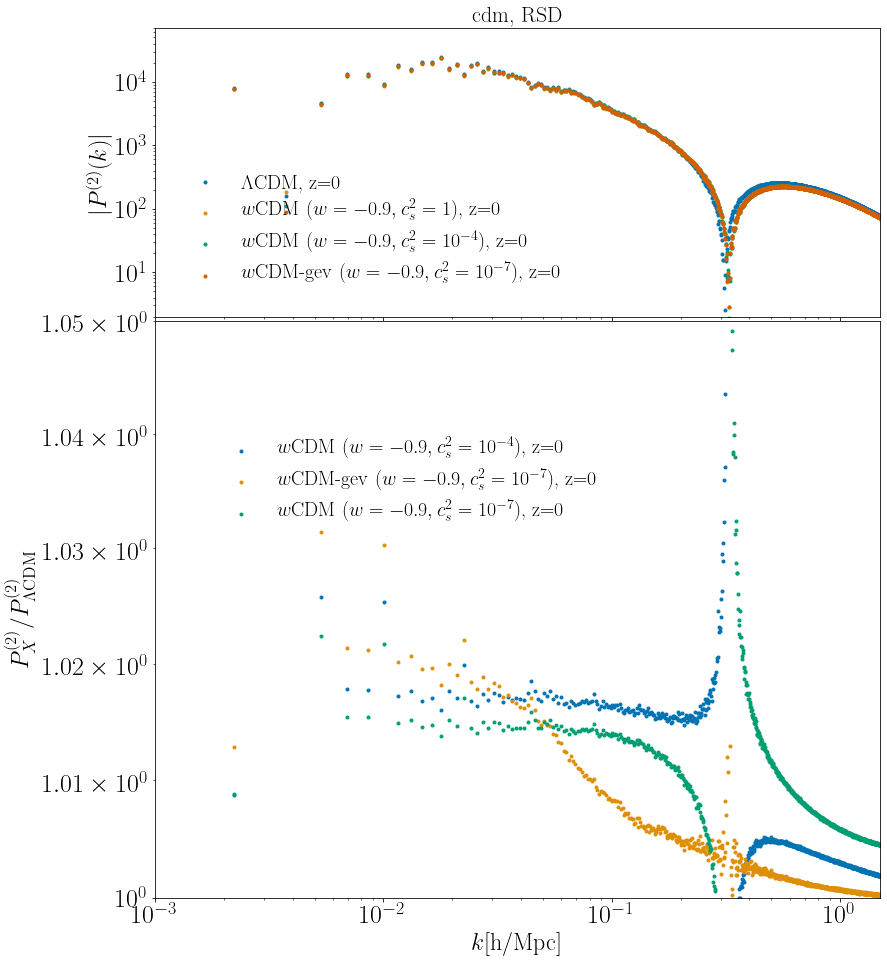

In [66]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'

file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
#         RSD ='noRSD'
#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
#         axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        RSD ='RSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
        axs[0].plot(k_w,np.abs(pk),".",color =Colors[l], lw=3,label=decrip[i]+redshift)

#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$|P^{(2)}(k)|$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e0,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.3, 0.3], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [1,2,3,4]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
#                 RSD ='noRSD'
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,2],:]
#                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="RSD"+decrip[num1]+" "+z[j])
                
                RSD ='RSD'
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,2],:]                
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
                l=l+1;

l=0

axs[1].set_ylabel(r'$P_X^{(2)}/P^{(2)}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1.0,1.05)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.35,0.72],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_cdm_quadrupole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


### quadrupole without RSD

Text(0.5, 0, '$k$[h/Mpc]')

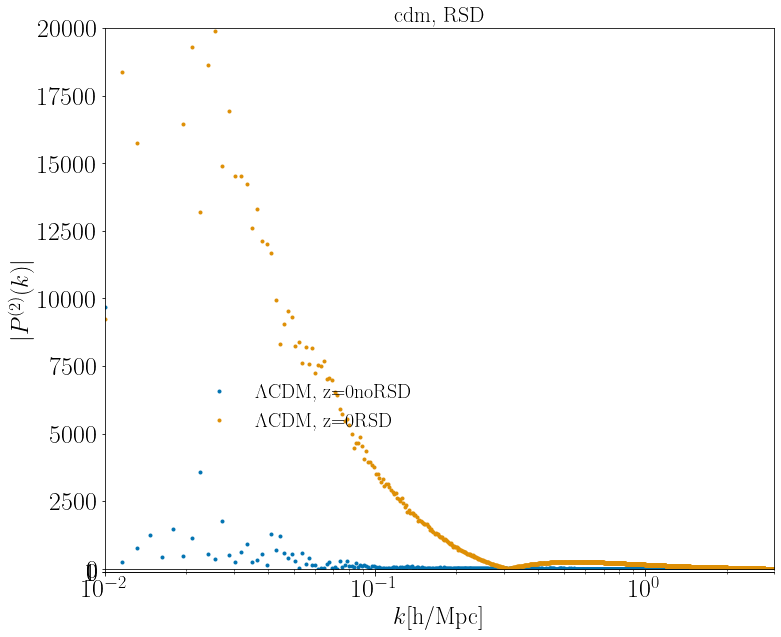

In [17]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(12,10),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,0]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'

file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
#         RSD ='noRSD'
#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
#         axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        RSD ='noRSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
        axs[0].plot(k_w,np.abs(pk),".",color =Colors[l], lw=3,label=decrip[i]+redshift+RSD)

        RSD ='RSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
        axs[0].plot(k_w,np.abs(pk),".",color =Colors[l+1], lw=3,label=decrip[i]+redshift+RSD)

#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$|P^{(2)}(k)|$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
# axs[0].set_yscale('log')

# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(-2.e1,2.e4)
axs[0].set_xlim(1.e-2,3.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.3, 0.3], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

# l=0
# for num1 in [0,1,2,3,4]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             redshift ="z="+str(j);
#             if(num1!=num2):
# #                 RSD ='noRSD'
# #                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
# #                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,2],:]
# #                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="RSD"+decrip[num1]+" "+z[j])
                
#                 RSD ='noRSD'
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,3],:]                
#                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#                 l=l+1;

# l=0

# axs[1].set_ylabel(r'$P_X^{(4)}/P^{(4)}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_ylim(0.93,1.05)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
# axs[1].legend(fontsize=20,bbox_to_anchor=[0.25,0.72],loc="center",frameon=False)
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_cdm_hexadecapole.pdf', format='pdf',dpi=300, bbox_inches='tight' )




# hexadecapole, CDM,  RSD comparison

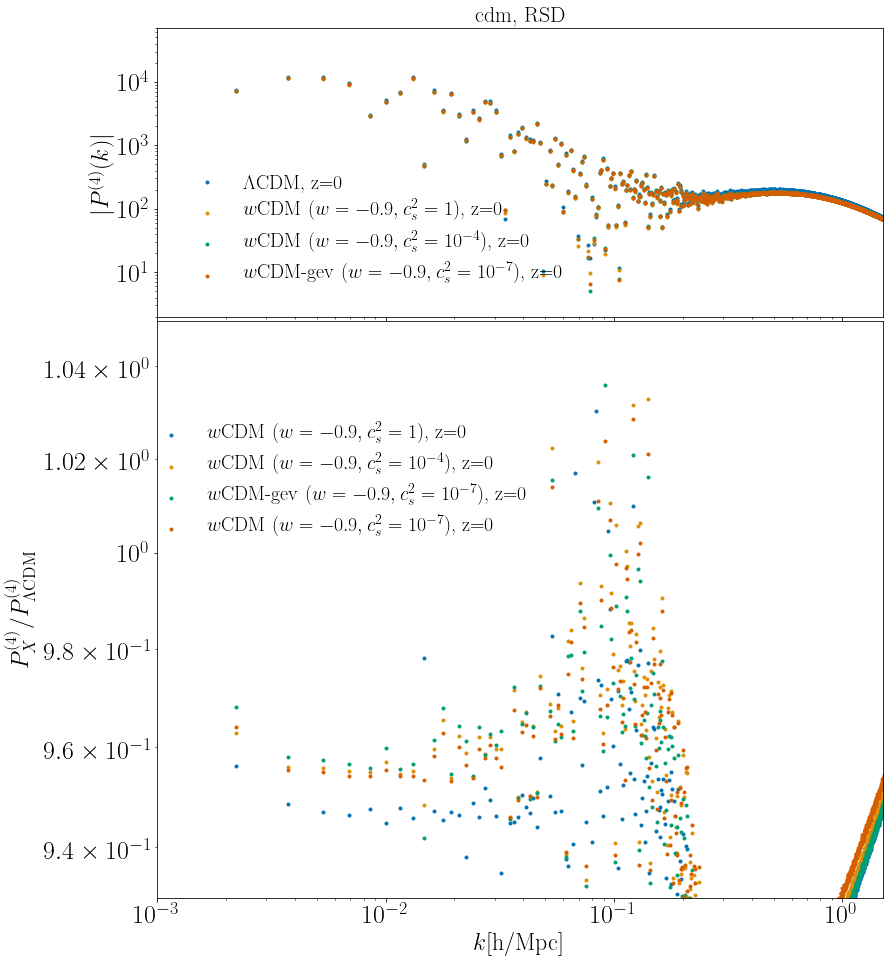

In [81]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'

file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
#         RSD ='noRSD'
#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
#         axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        RSD ='RSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,3],:]  
        axs[0].plot(k_w,np.abs(pk),".",color =Colors[l], lw=3,label=decrip[i]+redshift)

#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$|P^{(4)}(k)|$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e0,7.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.3, 0.3], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
            if(num1!=num2):
#                 RSD ='noRSD'
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,2],:]
#                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="RSD"+decrip[num1]+" "+z[j])
                
                RSD ='RSD'
                [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
                [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,3],:]                
                axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
                l=l+1;

l=0

axs[1].set_ylabel(r'$P_X^{(4)}/P^{(4)}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(0.93,1.05)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=20,bbox_to_anchor=[0.25,0.72],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
plt.savefig('RSD_cdm_hexadecapole.pdf', format='pdf',dpi=300, bbox_inches='tight' )




## hexadecapole without RSD

Text(0.5, 0, '$k$[h/Mpc]')

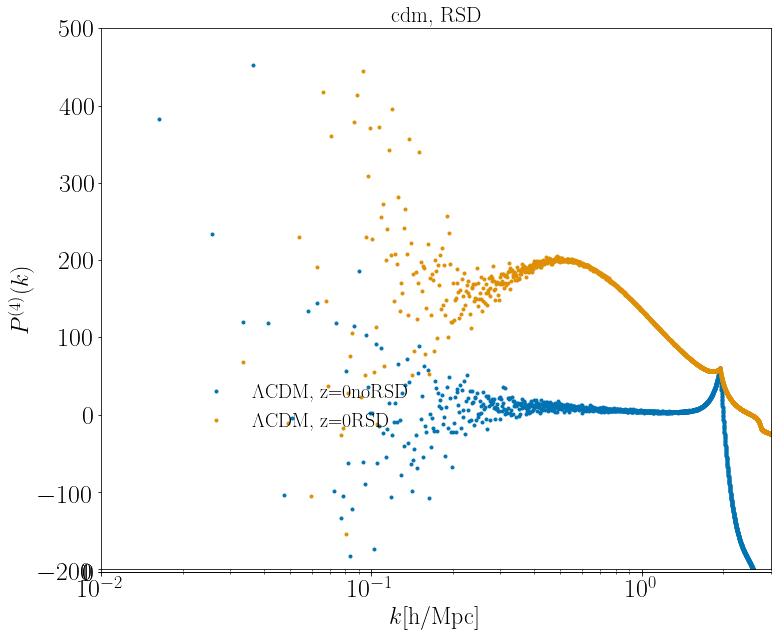

In [20]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(12,10),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,0]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'

file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]

l=0
for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
#         RSD ='noRSD'
#         [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,2],:]  
#         axs[0].plot(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+redshift)
        
        RSD ='noRSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,3],:]  
        axs[0].plot(k_w,(pk),".",color =Colors[l], lw=3,label=decrip[i]+redshift+RSD)

        RSD ='RSD'
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][redshift][[0,3],:]  
        axs[0].plot(k_w,(pk),".",color =Colors[l+1], lw=3,label=decrip[i]+redshift+RSD)

#         k_class = class_data['tk'][files_list_class[i]][redshift][:,0]
#         pk_class = class_data['tk'][files_list_class[i]][redshift][:,3]
#         axs[0].loglog(k_class, pk_class**2 *conversion ,"-",alpha=0.6,color =Colors[l], lw=3)
        l=l+1

axs[0].set_ylabel('$P^{(4)}(k)$',fontsize=24)
# axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
# axs[0].set_yscale('log')

# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(-2.e2,5.e2)
axs[0].set_xlim(1.e-2,3.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.3, 0.3], loc='center',frameon=False)
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

# l=0
# for num1 in [0,1,2,3,4]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             redshift ="z="+str(j);
#             if(num1!=num2):
# #                 RSD ='noRSD'
# #                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,2],:]
# #                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,2],:]
# #                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label="RSD"+decrip[num1]+" "+z[j])
                
#                 RSD ='noRSD'
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][redshift][[0,3],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][redshift][[0,3],:]                
#                 axs[1].plot(k1,(pk1)/(pk2),".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#                 l=l+1;

# l=0

# axs[1].set_ylabel(r'$P_X^{(4)}/P^{(4)}_{\Lambda \rm{CDM} }$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_ylim(0.93,1.05)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
# axs[1].legend(fontsize=20,bbox_to_anchor=[0.25,0.72],loc="center",frameon=False)
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
# plt.savefig('RSD_cdm_hexadecapole.pdf', format='pdf',dpi=300, bbox_inches='tight' )




# Matter power RSD different redshifts

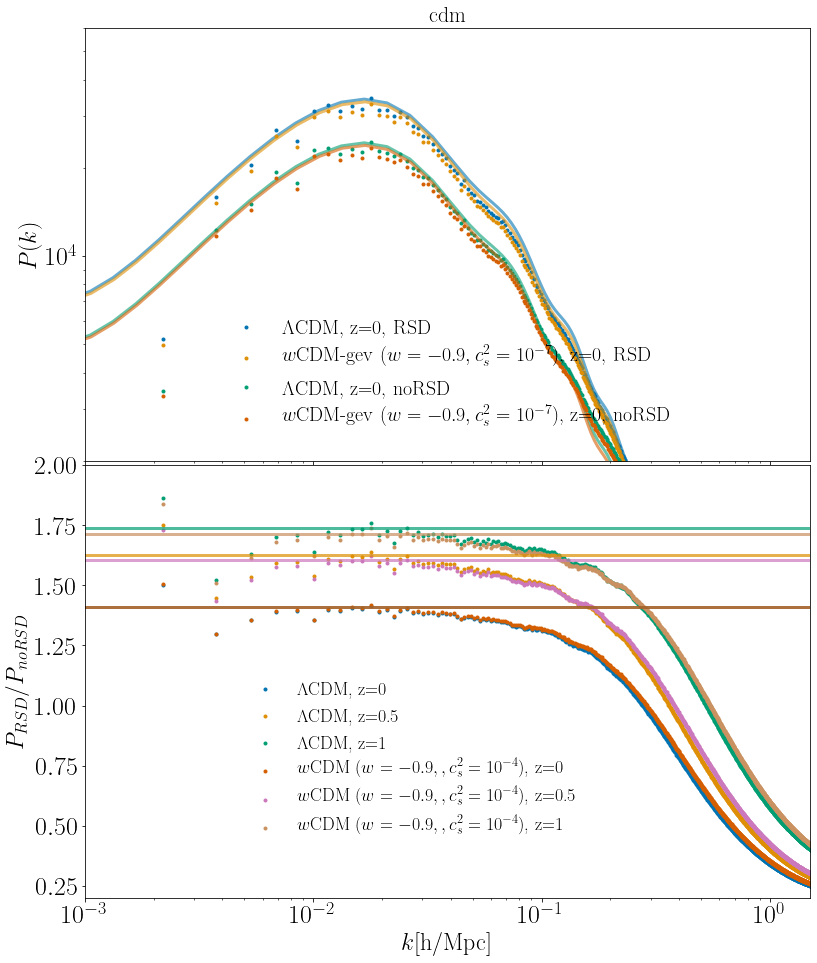

In [54]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,1.]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,2]: # file
    for j in [0]: # Redshifts
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][z[j]][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j]+", "+RSD)
        
        k_class = class_data['tk'][files_list_class[i]][z[j]][:,0]
        pk_class = class_data['tk'][files_list_class[i]][z[j]][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * np.double(rsd_coeff[files_list_class[i]][z[j]]) ,"-",alpha=0.6,color =Colors[l], lw=3)

        l=l+1
    
kind = 'cdm'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

for i in [0,2]: # file
    for j in [0]: # Redshifts
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][z[j]][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j]+", "+RSD)
        k_class = class_data['tk'][files_list_class[i]][z[j]][:,0]
        pk_class = class_data['tk'][files_list_class[i]][z[j]][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion  ,"-",alpha=0.6,color =Colors[l], lw=3)

        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e3,6.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=20,bbox_to_anchor=[0.5, 0.2], loc='center',frameon=False)
axs[0].set_title(kind, fontsize=22)
# Relative difference:

l=0
for num1 in [0,3]: # file 1
    for j in [0,1,2]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])

            l=l+1;
l=0
for num1 in [0,3]: # file 1
    for j in [0,1,2]: # Redshifts
            axs[1].axhline(y=np.double(rsd_coeff[files_list_class[num1]][z[j]]),color =Colors[l],alpha=0.7, lw=3)

            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{noRSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,2)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=18,bbox_to_anchor=[0.45,0.32],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
plt.savefig('RSD_noRSD_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


# cdm power RSD and no-RSD

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


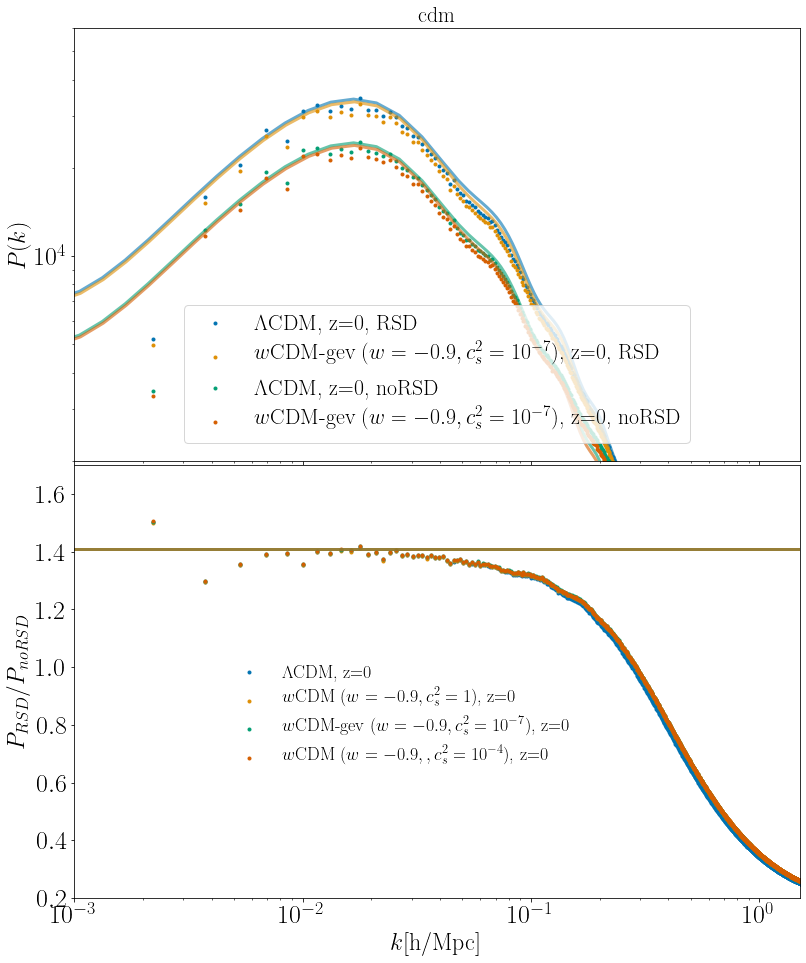

In [83]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,1.]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,2]: # file
    for j in [0]: # Redshifts
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][z[j]][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j]+", "+RSD)
        
        k_class = class_data['tk'][files_list_class[i]][z[j]][:,0]
        pk_class = class_data['tk'][files_list_class[i]][z[j]][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion * np.double(rsd_coeff[files_list_class[i]][z[j]]) ,"-",alpha=0.6,color =Colors[l], lw=3)

        l=l+1
    
kind = 'cdm'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

for i in [0,2]: # file
    for j in [0]: # Redshifts
        [k_w,pk]=data[kind][RSD][file[i]]['pow'][z[j]][[0,1],:]  
        axs[0].loglog(k_w,pk,".",color =Colors[l], lw=3,label=decrip[i]+z[j]+", "+RSD)
        k_class = class_data['tk'][files_list_class[i]][z[j]][:,0]
        pk_class = class_data['tk'][files_list_class[i]][z[j]][:,3]
        axs[0].loglog(k_class, pk_class**2 *conversion  ,"-",alpha=0.6,color =Colors[l], lw=3)

        l=l+1

axs[0].set_ylabel('$P(k)$',fontsize=24)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
# plt.yscale('log')
# axs[0].xticks(size = 25);
# axs[0].yticks(size = 25);
axs[0].set_ylim(2.e3,6.e4)
axs[0].set_xlim(1.e-3,2.e0)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.2], loc='center')
axs[0].set_title(kind, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,".",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])

            l=l+1;
l=0
for num1 in [0,1,2,3]: # file 1
    for j in [0]: # Redshifts
            axs[1].axhline(y=np.double(rsd_coeff[files_list_class[num1]][z[j]]),color =Colors[l],alpha=0.5, lw=3)

            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{noRSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,1.7)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=18,bbox_to_anchor=[0.45,0.42],loc="center",frameon=False)
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo vs cdm, RSD and noRSD redshift evolution

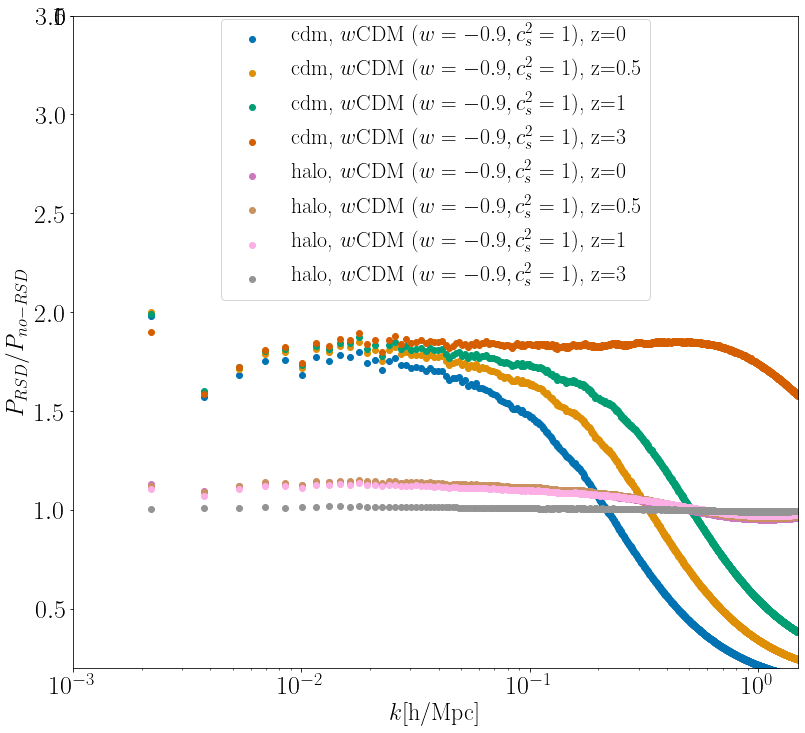

In [261]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


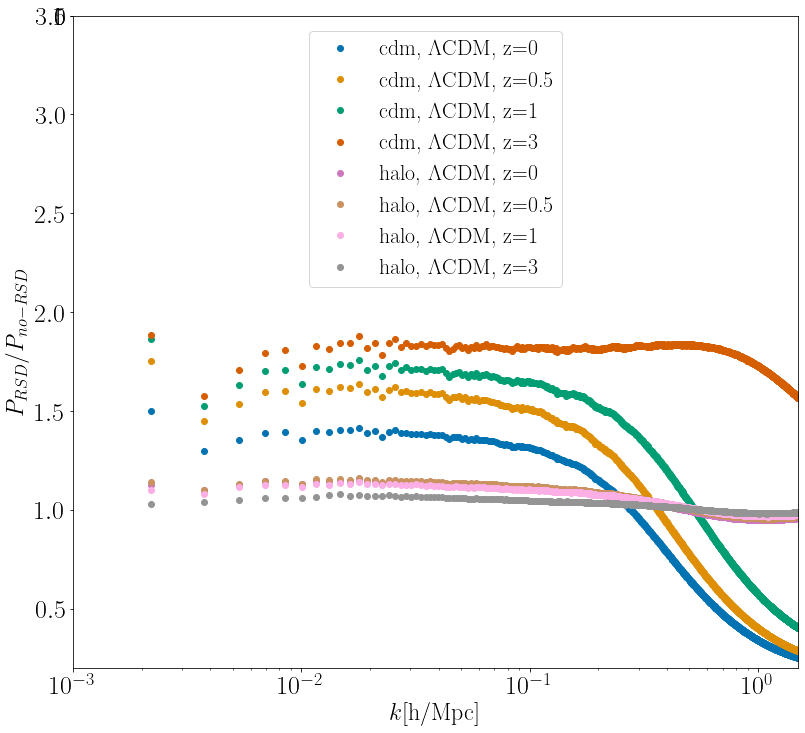

In [103]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [0]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$P_{RSD}/P_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo over cdm power spectrum

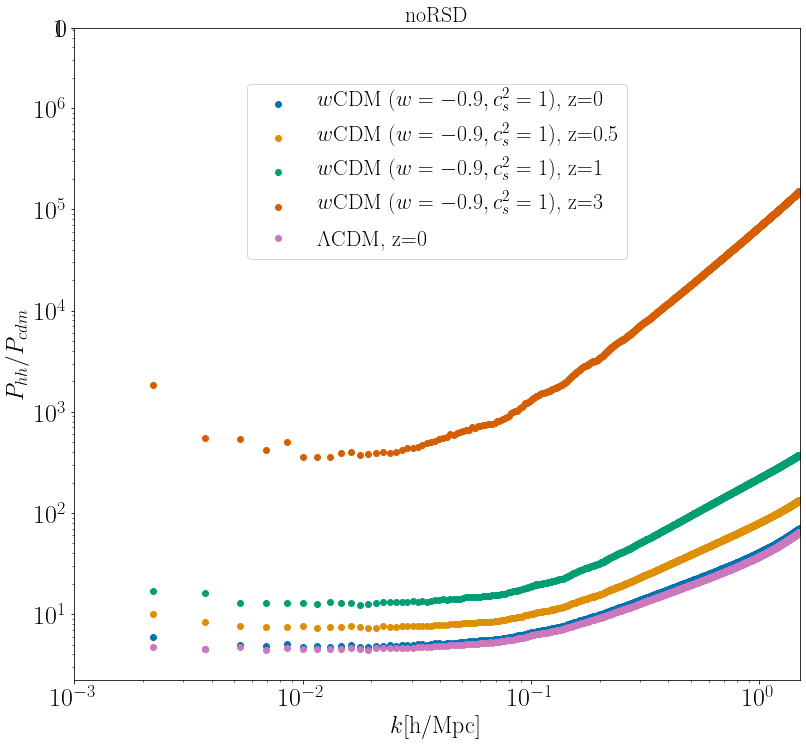

In [271]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='noRSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind1 = "cdm"
kind2 = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
for num1 in [0]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind1]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['noRSD'][file[num1]]['pow'][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
axs[1].set_title(RSD, fontsize=22)
axs[1].set_ylabel('$P_{hh}/P_{cdm}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
plt.yscale('log')
# axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


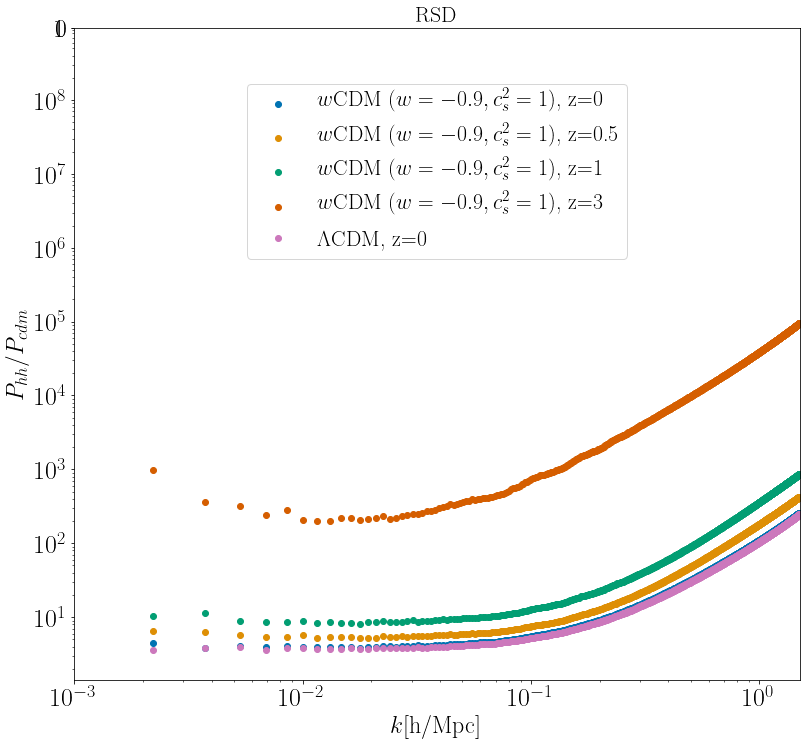

In [68]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind1 = "cdm"
kind2 = "halo"
l=0
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind1]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
        
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
            l=l+1;
for num1 in [1]: # file 1
    for j in [0,1,2,4]: # Redshifts
            [k1,pk1]=data[kind1]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
            [k2,pk2]=data[kind2]['RSD'][file[num1]]['pow'][z[j]][[0,1],:]
        
            axs[1].plot(k1,pk2/pk1,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])axs[1].set_title(RSD, fontsize=22)
axs[1].set_ylabel('$P_{hh}/P_{cdm}$',fontsize=24)
axs[1].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[1].set_xscale('log')
plt.yscale('log')
# axs[1].set_ylim(0.2,3.5)
axs[1].set_xlim(1.e-3,1.5)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.78], loc='center')
X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Correlation function cdm, no RSD

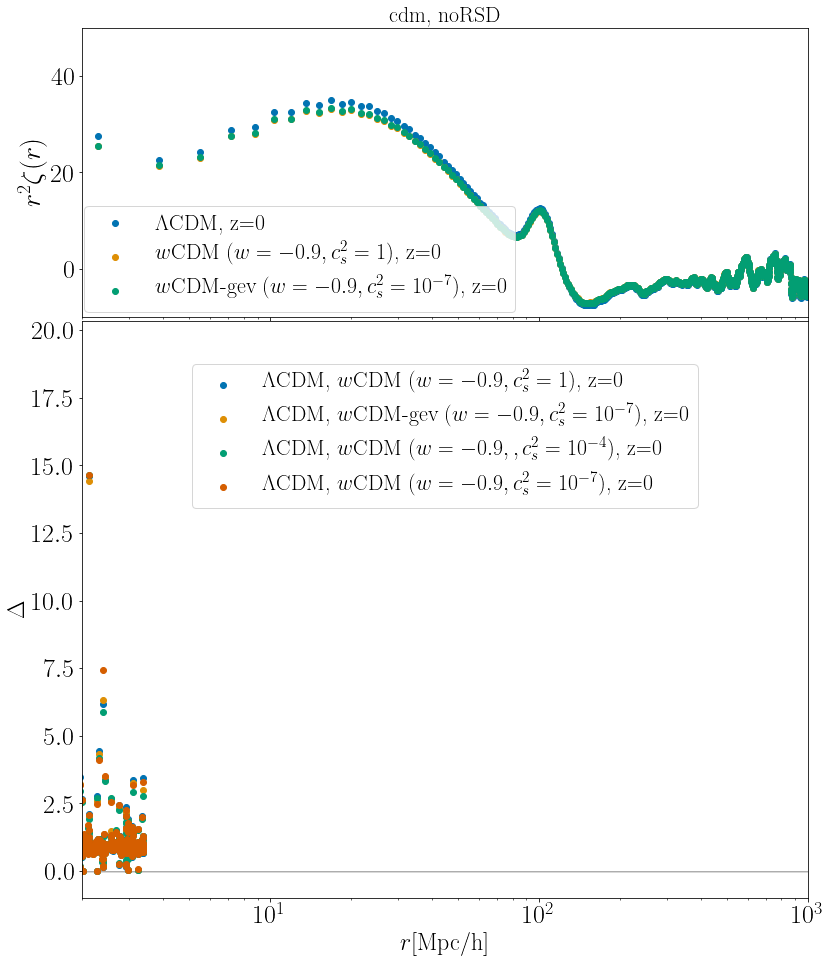

In [59]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='noRSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-10,50)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.3, 0.2], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(k1,(zeta1**2)/zsta2**2,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
# axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Correlation function cdm, RSD

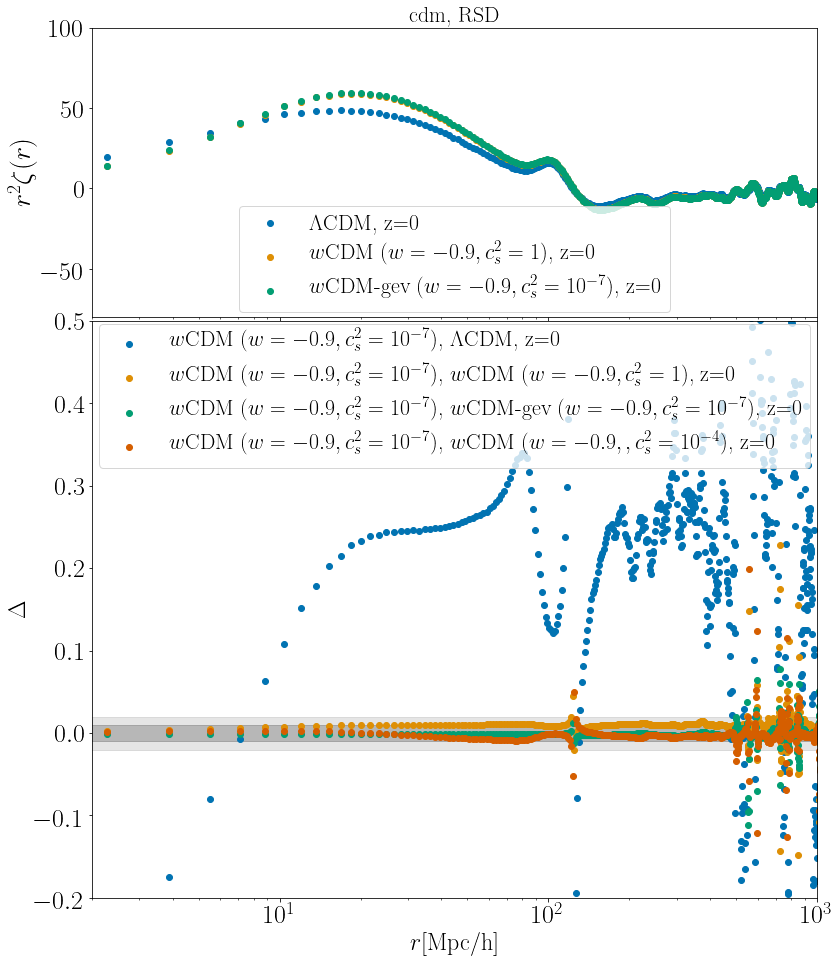

In [310]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-8.e1,1.e2)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.2], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(k1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.2,0.5)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.87], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo  Correlation function, noRSD

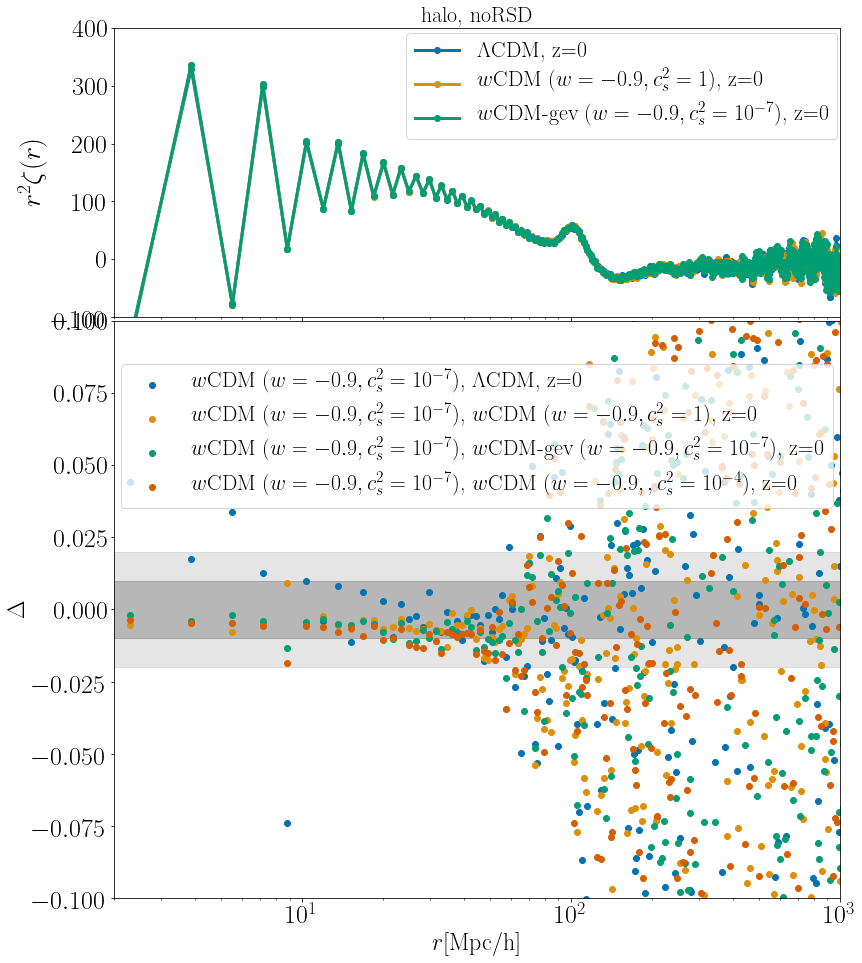

In [320]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='noRSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,400)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,1000)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# Halo  Correlation function, RSD

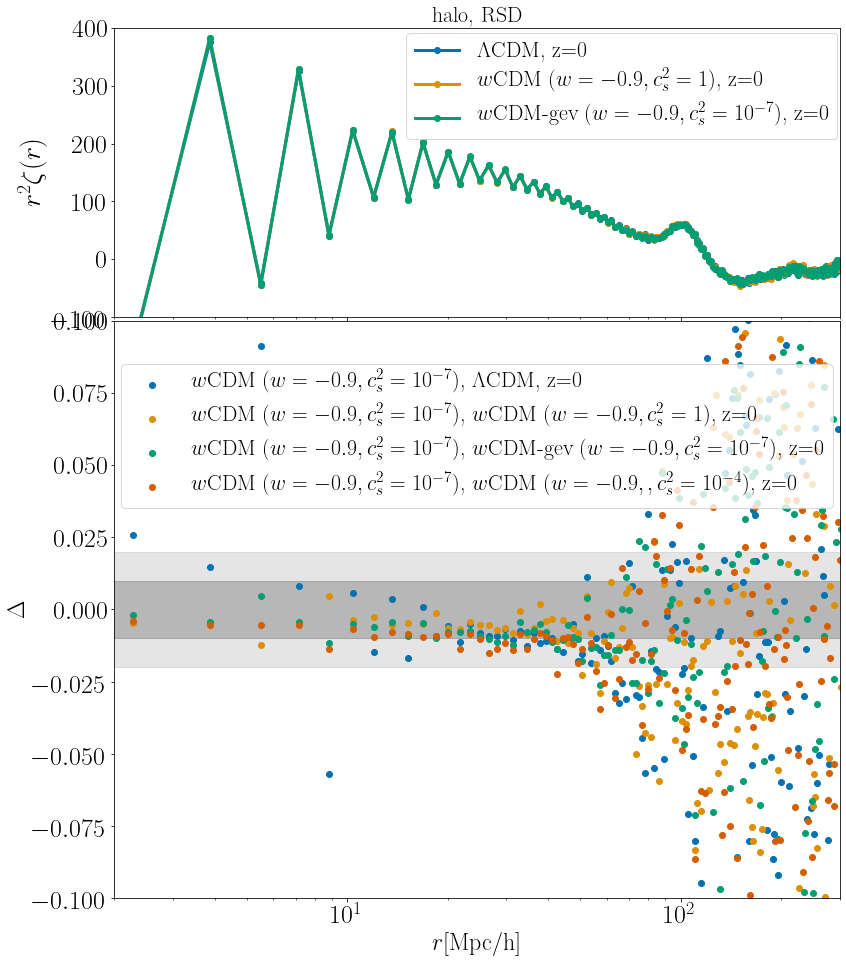

In [331]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,1],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,400)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,1],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,1],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.1)
axs[1].set_xlim(2,300)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# correlation function RSD, noRSD comparison

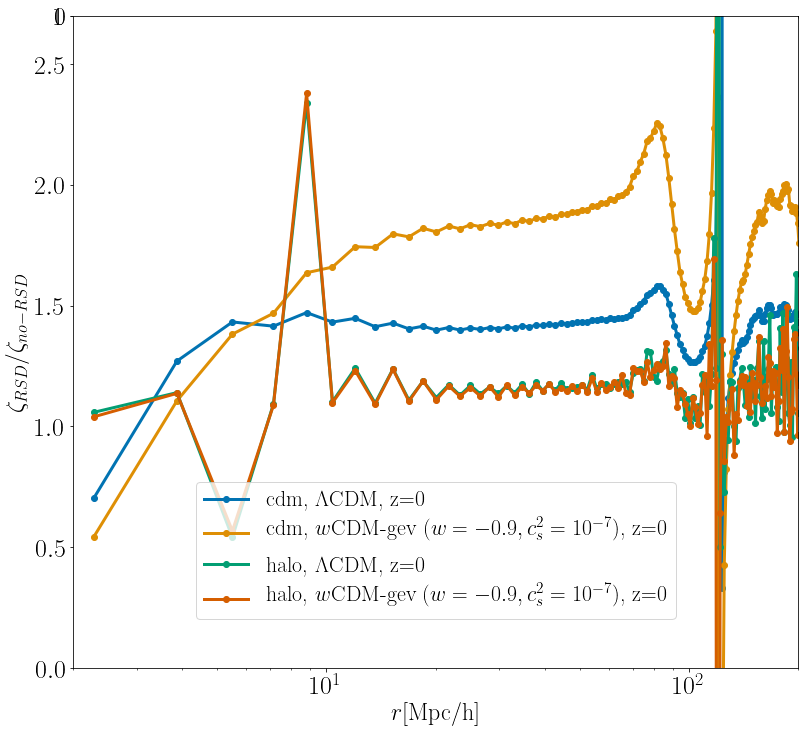

In [330]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,12),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[0,1]})
plt.subplots_adjust(hspace=0.0)



kind = 'halo'
file_type = 'cor'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0

kind = "cdm"
l=0
for num1 in [0,2]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]][file_type][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]][file_type][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"-o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;
kind = 'halo'
for num1 in [0,2]: # file 1
    for j in [0]: # Redshifts
            [k1,pk1]=data[kind]['noRSD'][file[num1]][file_type][z[j]][[0,1],:]
            [k2,pk2]=data[kind]['RSD'][file[num1]][file_type][z[j]][[0,1],:]
            axs[1].plot(k1,pk2/pk1,"-o",color =Colors[l], lw=3,label=kind+", "+decrip[num1]+" "+z[j])
            l=l+1;

axs[1].set_ylabel('$\zeta_{RSD}/\zeta_{no-RSD}$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('log')
axs[1].set_ylim(0,2.7)
axs[1].set_xlim(2,200)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.18], loc='center')
# X=np.arange(0.001,20,1)
# axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
# axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# quadrupole moment RSD, noRSD, halo

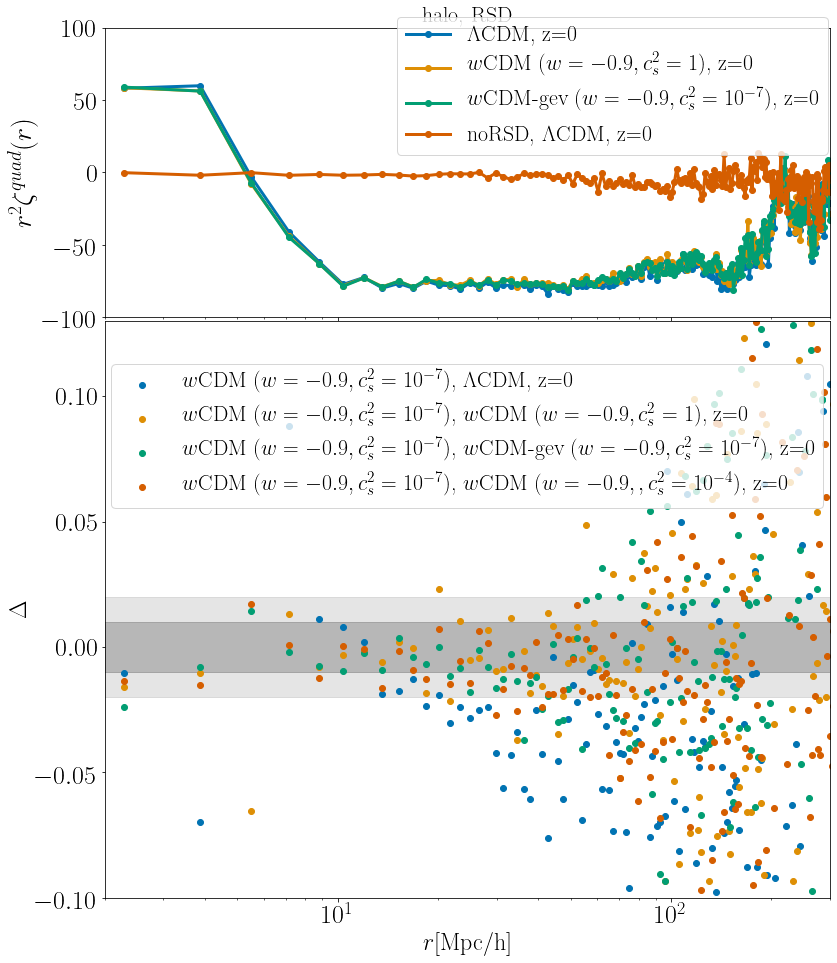

In [340]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1
        
for i in [0]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind]['noRSD'][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label="noRSD, "+decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta^{quad}(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-100,100)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.8], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,2],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,2],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
# plt.yscale('symlog')
axs[1].set_ylim(-0.1,0.13)
axs[1].set_xlim(2,300)
# axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)


# quadrupole moment RSD, noRSD, cdm

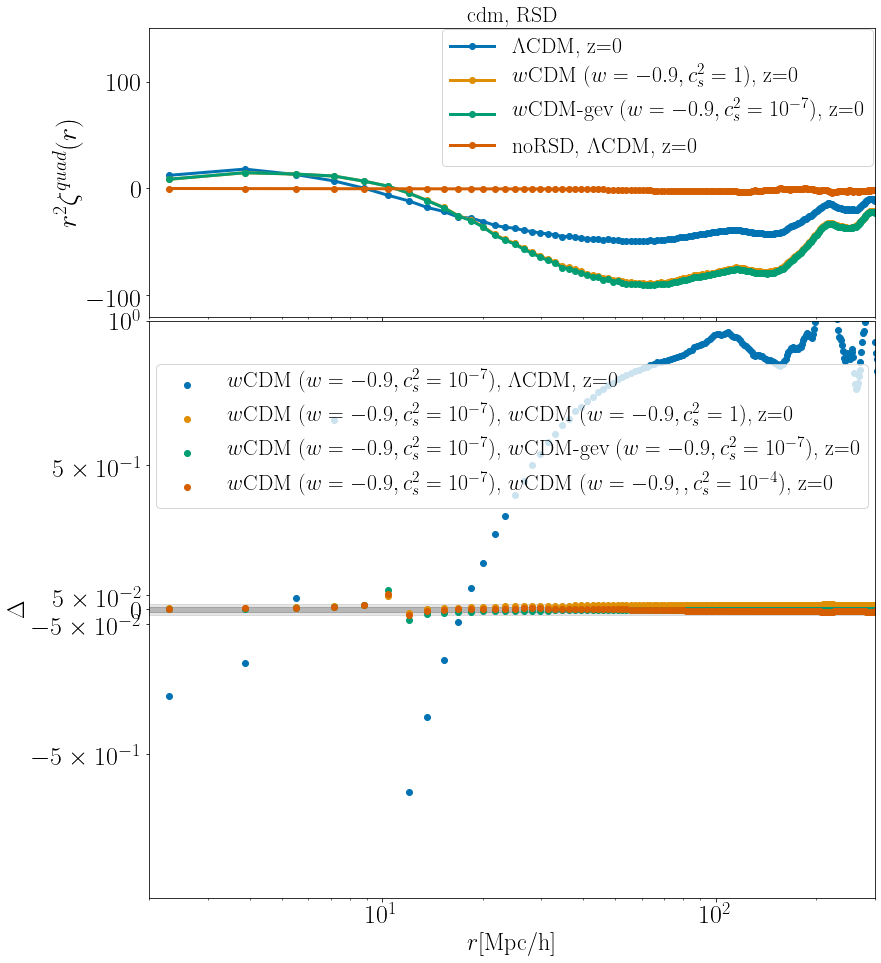

In [347]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'cdm'
RSD ='RSD'
file_type = 'cor'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM ($w=-0.9,, c_s^2=10^{-4}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind][RSD][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label=decrip[i]+z[j])
        l=l+1
        
for i in [0]: # file
    for j in [0]: # Redshifts
        [r,zeta]=data[kind]['noRSD'][file[i]][file_type][z[j]][[0,2],:]  
        axs[0].plot(r,zeta*r**2,"-o",color =Colors[l], lw=3,label="noRSD, "+decrip[i]+z[j])
        l=l+1

axs[0].set_ylabel('$r^2 \zeta^{quad}(r)$',fontsize=28)
axs[0].set_xlabel('$k$[h/Mpc]',fontsize=24)
axs[0].set_xscale('log')
axs[0].set_ylim(-120,150)
# axs[0].set_xlim(1.e-2,500)
axs[0].legend(fontsize=22,bbox_to_anchor=[0.7, 0.76], loc='center')
axs[0].set_title(kind+", "+RSD, fontsize=22)
# Relative difference:

l=0
for num1 in [0,1,2,3,4]: # file 1
    for num2 in [4]: # file2
        for j in [0]: # Redshifts
            if(num1!=num2):
                [r1,zeta1]=data[kind][RSD][file[num1]][file_type][z[j]][[0,2],:]
                [r2,zsta2]=data[kind][RSD][file[num2]][file_type][z[j]][[0,2],:]
                axs[1].plot(r1,(zsta2-zeta1)/zeta1,"o",color =Colors[l], lw=3,label=decrip[num2]+decrip[num1]+" "+z[j])
                l=l+1;

axs[1].set_ylabel('$\Delta$',fontsize=24)
axs[1].set_xlabel('$r$[Mpc/h]',fontsize=24)
axs[1].set_xscale('log')
plt.yscale('symlog')
axs[1].set_ylim(-1,1)
axs[1].set_xlim(2,300)
axs[1].set_yticks([-0.5,-0.05,0,0.05,0.5,1])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center')
X=np.arange(0.001,2000,20)
axs[1].fill_between(X, -1/100.,1/100.,color='k',alpha=.2)
axs[1].fill_between(X, -2/100.,2/100.,color='k',alpha=.1)
